## About the input file

- input file `predict_categories_dataset_ocrs.jsonl.gz` weights 335.8 MB  
about the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_documentation.txt  download the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_ocrs.jsonl.gz

- each line of the jsonl file contains OCRs associated barcodes.
- each OCR contains text, potentially in different languages

## What is done in this notebook
1. Make the OCR Dataframe
- A DataFrame is made from the jsonl.gz
- All the OCRs (text) of a product are concatenated
- For each product the different languages are detected.  


Problem: in some cases the text is too long. If we were to use a transformer model like Bert to predict categories, there is a major limitation: the maximum number of words Bert can handle is 500.
We need a way to extract only relevant words. Bellow, all the strategies used:

2. Selection strategies / Summerization strategies:
- main language strategy: only the main language is kept (i.e the lang in which there are many words and a good confidence score)
- TFIDF Selection strategy : The approach here is to filter by language and to create a TFIDF matrix. For each product of a given language we keep only the N-top words according to their TFIDF score.
- language intersection strategy:
We get words that are found in all the different languages detected.
- OCR intersection strategy:
We get found in all the different OCRs (i.e all the different images).
- Big words in the images strategy:
We fetch the biggest words in the images. They are found by choosing words that have the biggest bounding polygon (anchor detection box) for the least text. In other words we choose the words that have the biggest detection-box-size / character-length ratio


3. Final output: 
- When the original input text is not too long it remains as is, it is only cleaned with the `text_cleaner` there isn't any word selection at all.
- If the original input text has more than 500 characters, we pick the text of the main language.
- If the text of the main language is has still more than 500 characters we remove duplicated words.
- If there is still more than 500 characters, we then take the tfidf selection.
- Finally we add big words from images and "intersection words" from OCRs and languages.  



### Make DataFrame and ocr_text_dict from jsonl

In [1]:
import pandas as pd
import numpy as np
path_ocrs = os.path.abspath("INPUT_datasets/predict_categories_dataset_ocrs.jsonl.gz")
from utils.OCR_preprocessing import get_row_from_json_for_df, get_item_from_json_for_dict

In [3]:
"""approx time 15sec
Iterating through the jsonl to extract elements for the dataframe nad the ocr dictionnary.
"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
ocr_text_dict = {}
with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        #We take lines after 10 000 because those are potentially problematic.
        if i > 10000: 
            json_line = json.loads(line)
            if len(str(json_line['code'])) == 13:
                #for df
                row = get_row_from_json_for_df(json_line)
                rows.append(row)
                #for dict
                ocr_text_dict = get_item_from_json_for_dict(json_line, ocr_text_dict)

df = pd.DataFrame(rows, columns = ["code", "texts", "keys"]).drop_duplicates(subset = "code")
df['code'] = df['code'].astype(str)
df['texts'] = df['texts'].astype(str)
print(df.shape)
print(len(ocr_text_dict))

del rows

(790383, 3)
597242


In [4]:
is_real_ean = df['code'].str.len() == 13
df = df[is_real_ean]
print("after removing non normalized codes", df.shape)
### Keep only texts > 10 char
len_sup_10 = (df["texts"].str.len()> 10)
df = df[len_sup_10]
print("after removing short texts", df.shape)


after removing non normalized codes (790383, 3)
after removing short texts (596550, 3)


### Extract main language from text

for each text associated with a barcode, there are potentially many languages used to describe the product.
The aim of this section is to detect the main language and to extract its text.

In [2]:
PRETRAINED_MODEL_PATH = 'fasttext_weights/lid.176.bin'
from utils.OCR_language_extraction import get_lang_items_from_pd_textlist

In [5]:
"""approx time 2min15"""
text_list, lang_dict_list, main_lang_list = get_lang_items_from_pd_textlist(df['texts'],PRETRAINED_MODEL_PATH)
main_lang_dict = {code: dic for (code,dic) in zip(df["code"], lang_dict_list)}
#assign new items to df
df["text_main_lang"] = text_list
df["main_lang"] = main_lang_list
df.head(2)

100%|██████████| 596550/596550 [02:16<00:00, 4364.55it/s]


,code,texts,keys,text_main_lang,main_lang
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en


### Clean the text

In [6]:
from utils.OCR_preprocessing import text_cleaner, parallel_calc

In [45]:
""" Non parallelized version - approx time 2m"""
#df["text_cleaned"] = df["text_main_lang"].apply(lambda x: text_cleaner(x))
#df = df.set_index("code", drop = True)

""" Parallelized version - approx time 30sec"""
# simple wrapper code around text_cleaner to parallelize the work
df["text_main_lang_cleaned"] = parallel_calc(text_cleaner, df["text_main_lang"])

In [44]:
"""approx time 1min"""
df["original_text_cleaned"]  = parallel_calc(text_cleaner, df["texts"])

In [46]:
df.head(3)

,code,texts,keys,text_main_lang,main_lang,text_cleaned,tfidf_selection,intersection_words_lang,intersection_words_ocr,big_words,word_selection,original_text_cleaned,text_main_lang_cleaned
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en,Nutrition Facts servings container Serving Siz...,Nutrition Facts servings container Serving Siz...,,,Facts Calories Nutrition servings container Se...,Facts Calories Nutrition servings container Se...,Nutrition Facts servings container Serving Siz...,Nutrition Facts servings container Serving Siz...
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en,Includes Added Sugars Nutrition Facts servings...,Includes Added Sugars Nutrition Facts servings...,,,Steves Eds ORIGINAL Louisiana Hot Sauce,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,Includes Added Sugars Nutrition Facts servings...,Includes Added Sugars Nutrition Facts servings...
2,0021078019091,SOURCE NATURALS\nDIETARY SUPPLEMENT\nTRUE WHEY...,[1],SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,en,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,,,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...


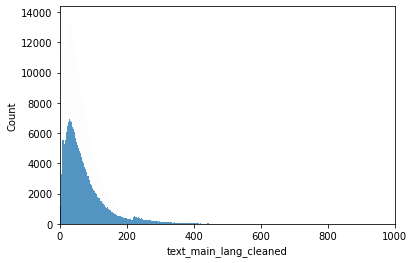

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_main_lang_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


### TFIDF Trick

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import clear_output
from utils.OCR_word_selection import get_freq_dict, get_best_tfidf_words_o
from tqdm import tqdm

df["tfidf_selection"] = ""
clear_output()

def make_params():
    """makes parameters for get_best_tfidf_words_o"""
    params = {
    "feature_names": feature_names,
    "text_series": sub_df_text_series,
    "tfidf_matrix": tfidf_matrix,
    "freq_dict": freq_dict,
    "N_words_to_pick": 120
    }
    return params

In [11]:
"""takes approx 3min30"""

problematic_langs = []
df = df.reset_index(drop = True)
freq_dict = get_freq_dict(df["text_main_lang_cleaned"])
for lang in df["main_lang"].unique():
    print("lang:", lang)
    lang_filter = df["main_lang"]== lang 
    sub_df_text_series = df.loc[lang_filter, "text_main_lang_cleaned"]
    try:
        vectorizer = TfidfVectorizer(max_df = 0.8)
        tfidf_matrix = vectorizer.fit_transform(sub_df_text_series)
        feature_names = vectorizer.get_feature_names_out()
        #we use make_params to make the code more concise
        text_selection_list = [get_best_tfidf_words_o(i, **make_params()) for i in tqdm(range(sub_df_text_series.shape[0]))]
        df.loc[lang_filter, "tfidf_selection"] = text_selection_list
    except:
        problematic_langs.append(lang)
    clear_output()


In [15]:
len(problematic_langs)

21

In [12]:
df["tfidf_selection"].str.split().str.len().sort_values(ascending = False)

44749     120
1860      120
275947    120
454712    120
409517    120
         ... 
296526      0
234325      0
78476       0
592551      0
142616      0
Name: tfidf_selection, Length: 596550, dtype: int64

### "Intersection words trick"

In [13]:
from utils.OCR_word_selection import get_intersect_words_lang, get_intersect_words_ocr

In [14]:
"""takes approx 1min30"""
intersection_list_lang = parallel_calc(get_intersect_words_lang, lang_dict_list)
print("ratio:", len([item for item in intersection_list_lang if item != ""]) / len(intersection_list_lang))

ratio: 0.14662308272567262


In [15]:
"""takes approx 56sec"""
sub_ocr_text_dict_list = [ocr_text_dict[code] for code in df["code"]]
intersection_list_ocr = parallel_calc(get_intersect_words_ocr, sub_ocr_text_dict_list)
print("ratio:", len([item for item in intersection_list_ocr if item != ""]) / len(intersection_list_ocr))

ratio: 0.4644321515380102


In [43]:
df["intersection_words_lang"] = intersection_list_lang
df["intersection_words_ocr"] = intersection_list_ocr

In [17]:
df["intersection_words_ocr"].str.split().str.len().sort_values(ascending = False)

315604    30
70086     30
32122     30
275024    30
115303    30
          ..
261679     0
261676     0
261675     0
261672     0
596549     0
Name: intersection_words_ocr, Length: 596550, dtype: int64

### Fetch big words from images

In [18]:
import gzip
import json
from utils.OCR_word_selection import get_big_words_from_txt_annotations

In [19]:
big_words_dict = {}
i_last = -1

In [73]:
"""takes approx 7m30"""
txt_annotations_path = "INPUT_datasets/txtannotations.jsonl.gzip"

with gzip.open(txt_annotations_path) as f:
    for i, line in enumerate(f):
        if i > i_last:
            i_last +=1
            json_str = line.decode('utf-8')
            txt_annotations = json.loads(json_str)
            barcode = list(txt_annotations.keys())[0]
            if str(barcode) in big_words_dict:
                sentences_list = [get_big_words_from_txt_annotations(txt_annotations[barcode][key]) for key in sorted(txt_annotations[barcode].keys())]
                if len(big_words_dict[str(barcode)]) <= 500:
                    big_words_dict[str(barcode)] +=  " " + " ".join(sentences_list)
            else:
                sentences_list = [get_big_words_from_txt_annotations(txt_annotations[barcode][key]) for key in sorted(txt_annotations[barcode].keys())]
                big_words_dict[str(barcode)] = " ".join(sentences_list)

        if i %250000 == 0:
            print(i)
  

0
250000
500000
750000
1000000


In [74]:
len(big_words_dict)

375415

In [20]:
#"""
import pickle
path = "barcodes_dict_with_new_ones.pkl"
with open(path, 'rb') as file:
    big_words_dict = pickle.load(file)
len(big_words_dict)
#"""

375415

In [47]:
df["big_words"] = df["code"].apply(lambda x: big_words_dict[str(x)] if str(x) in big_words_dict else '')

In [22]:
df["big_words"].str.split().str.len().sort_values(ascending = False)

142417    140
141865    112
85698     110
157713    110
190957    110
         ... 
448646      0
448647      0
448648      0
448650      0
596549      0
Name: big_words, Length: 596550, dtype: int64

### Make output df

In [23]:
from utils.OCR_preprocessing import remove_duplicates

In [48]:
"""takes approx 15 sec"""

df["word_selection"] = (
    df["big_words"].astype(str) + ". " +
    df["intersection_words_ocr"].fillna("").astype(str) + ". " +
    df["intersection_words_lang"].fillna("").astype(str) + ". " +
    df.apply(
        lambda x: x["original_text_cleaned"] if len(x["original_text_cleaned"]) < 500 
        else x["text_main_lang_cleaned"]if len(x["text_main_lang_cleaned"]) < 500
        else (remove_duplicates(x["text_main_lang_cleaned"]) if len(remove_duplicates(x["text_main_lang_cleaned"]).split()) < 80
        else x["tfidf_selection"]) ,axis = 1).astype(str)
    )


In [50]:
df[df["word_selection"] == ""].shape

(0, 13)

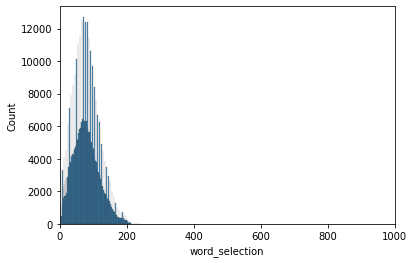

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['word_selection'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


In [26]:
df['word_selection'].str.split().str.len().sort_values(ascending = False)

169446    240
22709     240
169470    235
41484     230
169108    230
         ... 
564292      3
519901      3
216463      3
322997      3
446085      3
Name: word_selection, Length: 596550, dtype: int64

In [55]:
#df.to_pickle("OUTPUT_OCR_dataset/dataset.pkl")

In [58]:
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df = df[~empty_or_noise]
print(df.shape)



noise or empty lines: 194
(596356, 12)


### Check Results

In [42]:
import pandas as pd
df = pd.read_pickle("OUTPUT_OCR_dataset/dataset.pkl")
df["code"] = df["code"].astype(str)

In [59]:
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df = df[~empty_or_noise]
print(df.shape)


noise or empty lines: 0
(596356, 12)


In [112]:
from  utils.OCR_word_selection import show_images_from_barcode, get_big_words_from_image_clean, make_link_from_barcode
import re

In [61]:
df.columns

Index(['code', 'texts', 'keys', 'text_main_lang', 'main_lang',
       'tfidf_selection', 'intersection_words_lang', 'intersection_words_ocr',
       'big_words', 'word_selection', 'original_text_cleaned',
       'text_main_lang_cleaned'],
      dtype='object')

In [107]:
df.reset_index(drop=True).loc[(df["main_lang"] == "fr").reset_index(drop=True), "texts"].str.len().sort_values(ascending = False).head(30)

460335    47020
168364    39544
198768    38614
78551     29492
78567     29274
168790    27206
296363    26640
168168    25232
110304    24441
265744    24347
24678     23603
27640     23043
169690    22867
199640    22751
169143    22498
154187    21732
168488    21375
169604    20928
356032    20345
382309    20118
78531     19873
167776    19585
154097    19555
216653    19488
24609     19448
24584     19316
168063    18999
374113    18898
61762     18684
221622    18195
Name: texts, dtype: int64

In [109]:
#i = np.random.choice(range(df.shape[0]))
#i = 10157 # maitre coq volaille 0215703025452
#i = 20865 #knorr 3011360020178
#i = 363851 #bolognese sauce - 5000354914829
#i = 65210 # andouilettes - 3278910707327
#i = 27073 # bonduelle conconmbre fromage blanc  -3083681008616
#i = 151249 # macaroni everyday - 5400141165043
#i = 168364
i = 78531
barcode = df["code"].iloc[i]
print(i)
print(df["word_selection"].iloc[i])
print(len(df["word_selection"].iloc[i].split()))
print(barcode)
show_images_from_barcode(barcode, df)

78531
DD at enurAcido connosnsumidor ca DTo Plus SADAVELHAulano di Meer OM HI SSe PBarras βρμη εύa gerst στάριολκής arôme σ Fitness CHOCOLATE Tradizionale Coal Nestle pr CHOCOLAT CHOCOLADE CIOCCOLATO kca invertido extracto malta cebada hu Casca carbonato Calico Puede contener à en blé au Barre mais malt avoine acide pantothénique Nestle itness CHOCOLATE Energy CHOCOLAT CHOCOLADE CIOCCOLATO EOKOAATA Fitness OCOLATE Nestle CHOCOLADE kc CIOCCOLATO ZOKOAATA LAT Energy Fitness Nestle Energy CHOCOLATE CHOCOLAT CHOCOLADE CIOCCOLATO EOKOAATA. . . complet Je itanines aun danoir alimentaton varie BREAKFAST CEREAL BAR Barre Céréales Rarre nutritive cadre un PETIT DÉJEUNER Les vitamines contribuent métabolisme normal réduire important avoir variée équilibrée Volkorengranen ingrediënt Cereales Integrales Fibra artificiel arôme Zonder kunstmatige Lípidos quais açúcares µg portions doivent adaptées âge RWE Referentie waarde Valores Société Nestlé PAP en GENIET extrato malte Service consommateurs Belg

In [61]:
big_words_dict[barcode]

'Bonduelle Concombre au Fromage blanc Ciboulette keal Valeurs nutritionnelles SALADE CONCOMBRES AU FROMAGE BLANC CIBOULETTE Energie Matières'

In [111]:
len(input_text.split())

2861

In [110]:
input_text = df["texts"].iloc[i]
final_selection = df["word_selection"].iloc[i]
text_clean = df["text_main_lang_cleaned"].iloc[i]
text_tf = df["tfidf_selection"].iloc[i]
text_insct_lang = df["intersection_words_lang"].iloc[i]
text_insct_ocr = df["intersection_words_ocr"].iloc[i]
barcode = df["code"].iloc[i]


print(barcode)
print(re.sub(r"\n", " ", input_text))
print("\n ____ final selection ____")
print(final_selection)
print("\n ____ text of main language after cleaning ____")
print(text_clean)
print("\n ____ text selection with tdidf score")
print(text_tf)
print("\n ____ text selection - intersection between languages ____")
print(text_insct_lang)
print("\n ____ text selection - intersection between OCRs ____")
print(text_insct_ocr)
print("\n ___ text selection - big words from image ____")
if barcode in big_words_dict:
    print(big_words_dict[barcode])

3387390320008
Nestle Whole Grain No.1 Ingredient' Source of Fibre? No Artificial Colours or Flavours³ Chocolate Fitness NUTRI-SCORE ABCDE ABCDENUTRITIOUS ENERGY* BREAKFAST CEREAL BAR" "Barre de céréales pour le petit-déjeuner / Graanreep voor het ontbijt / Barra de Cereais de Pequeno-Almoço *B-vitamins contribute to normal energy-yielding metabolism as part of a varied and balanced diet and a healthy lifestyle x6 1  Chocelatê स FitneSS Whole Grain No.1 Ingredient' complet Je itanines 8L,83,85 et86 antibuent aun lestimporant danoir ne alimentaton varie et equibret n mode e iesin. Nestlē No Artificial Colours or Flavours3 Mma enerelerant metablismeende vemindering an vempeidheiden moeheit. Hetis belangik om een Source of Fibre? ontituen pra onomal meabolismo produtor de Eerje. Fimprtantesegui um aimentaĝ varada equibrade eum entlo de vida atn. 4 Chocolate Sans alorant artficel n arime atficel Zonder Fitness Sem corantes nem aronmas artiGas. Choclat Cholade Chocolate epu 141 g 16x 235 gC 

In [69]:
barcode = "3560070851003"
get_big_words_from_image_clean(barcode, df = df)

'ALM SAUMON ATLANTISCHE ATLANTIQUE Pavés BEVROREN CONGELÉ Moten Qualité sans arête peau Kwaliteit zonder graat ZALM SAUMON ATLANTIQUE ATLANTISCHE BEVROREN Moten Pavés CONGELÉ Nettogewicht Qualité FILIÈRE sans arête peau Kwaliteit'